# **Importing the Dependencies**

In [1]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# **Import and Preprocessing**

**Data Import**

In [2]:
uploaded=files.upload()

Saving Train.csv to Train.csv


In [3]:
sales=pd.read_csv(io.BytesIO(uploaded['Train.csv']))

**Basic Info**

In [4]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
print(sales.describe())
print(sales.info())

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800  
<class 'pandas.core.frame.DataFrame'>
RangeIn

**Check for Missing Values**

In [6]:
sales.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


**Handling Missing Values**

***Numerical Features***

In [7]:
mean_of_Item_Weight=sales['Item_Weight'].mean()
sales['Item_Weight'].fillna(mean_of_Item_Weight,inplace=True)

<ipython-input-7-2fab1815230f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales['Item_Weight'].fillna(mean_of_Item_Weight,inplace=True)


***Categorical Features***

In [8]:
mode_of_Outlet_Size=sales.pivot_table(values='Outlet_Size',columns='Outlet_Type', aggfunc=(lambda x:x.mode()[0]))
print(mode_of_Outlet_Size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [9]:
missing_for_Outlet_Size=sales['Outlet_Size'].isnull()
print(missing_for_Outlet_Size)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [10]:
sales.loc[missing_for_Outlet_Size,'Outlet_Size']=sales.loc[missing_for_Outlet_Size,'Outlet_Type'].apply(lambda x: mode_of_Outlet_Size[x] )

In [11]:
sales.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


**Preprocessing**

***Separating X and Y***

In [12]:
x=sales.drop(['Item_Outlet_Sales','Item_Identifier'],axis=1)
y=sales['Item_Outlet_Sales']

**Figures of Numerical Features**

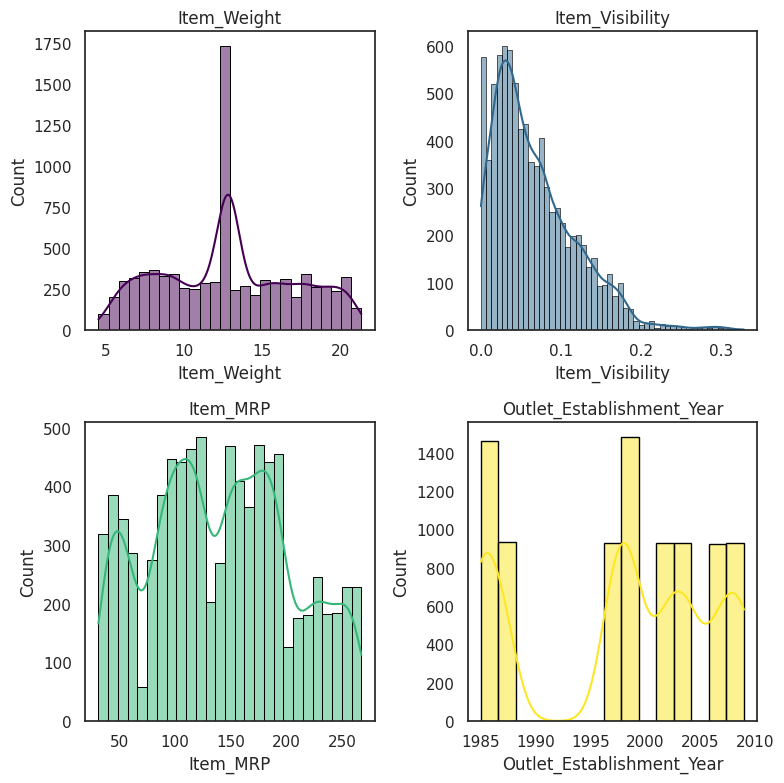

In [13]:
plt.figure(figsize=(8,8))
sns.set(style="white", palette="muted")
colors = plt.cm.viridis(np.linspace(0, 1, len(x[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year']].columns)))

for i, col in enumerate(x[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year']].columns):
    plt.subplot(2, 2, i + 1)
    sns.histplot(x[['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year']][col], kde=True, color=colors[i], edgecolor="black")
    plt.title(col)
    plt.tight_layout()

plt.show()

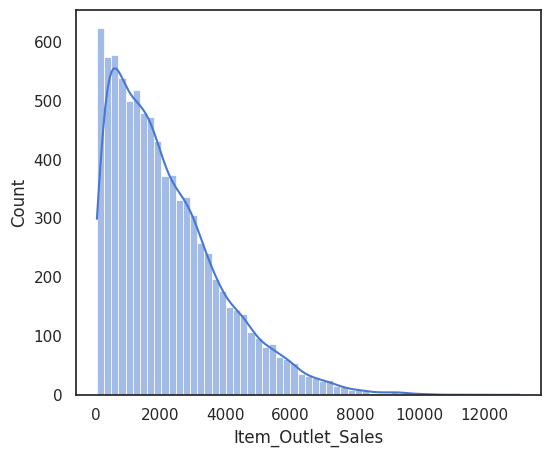

In [14]:
plt.figure(figsize=(6,5))
sns.histplot(y,kde=True)
plt.show()

**Figures of Categorical Features**

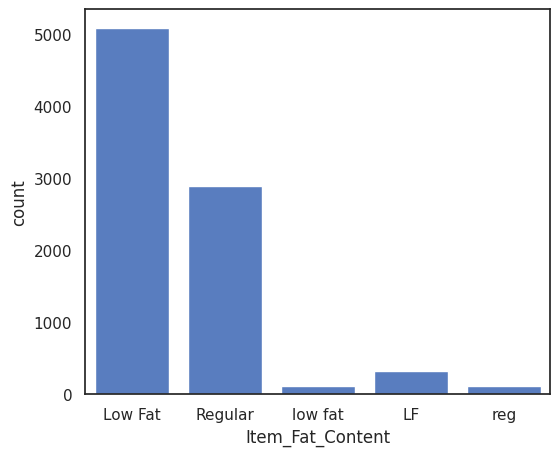

In [15]:
plt.figure(figsize=(6,5))
sns.countplot(x='Item_Fat_Content',data=x)
plt.show()

***Recode***

In [16]:
x['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5089
Regular,2889
LF,316
reg,117
low fat,112


In [16]:
x.replace({'Item_Fat_Content':{'low fat':'Low Fat', 'LF':'Low Fat', 'reg':'Regular'}},inplace=True)

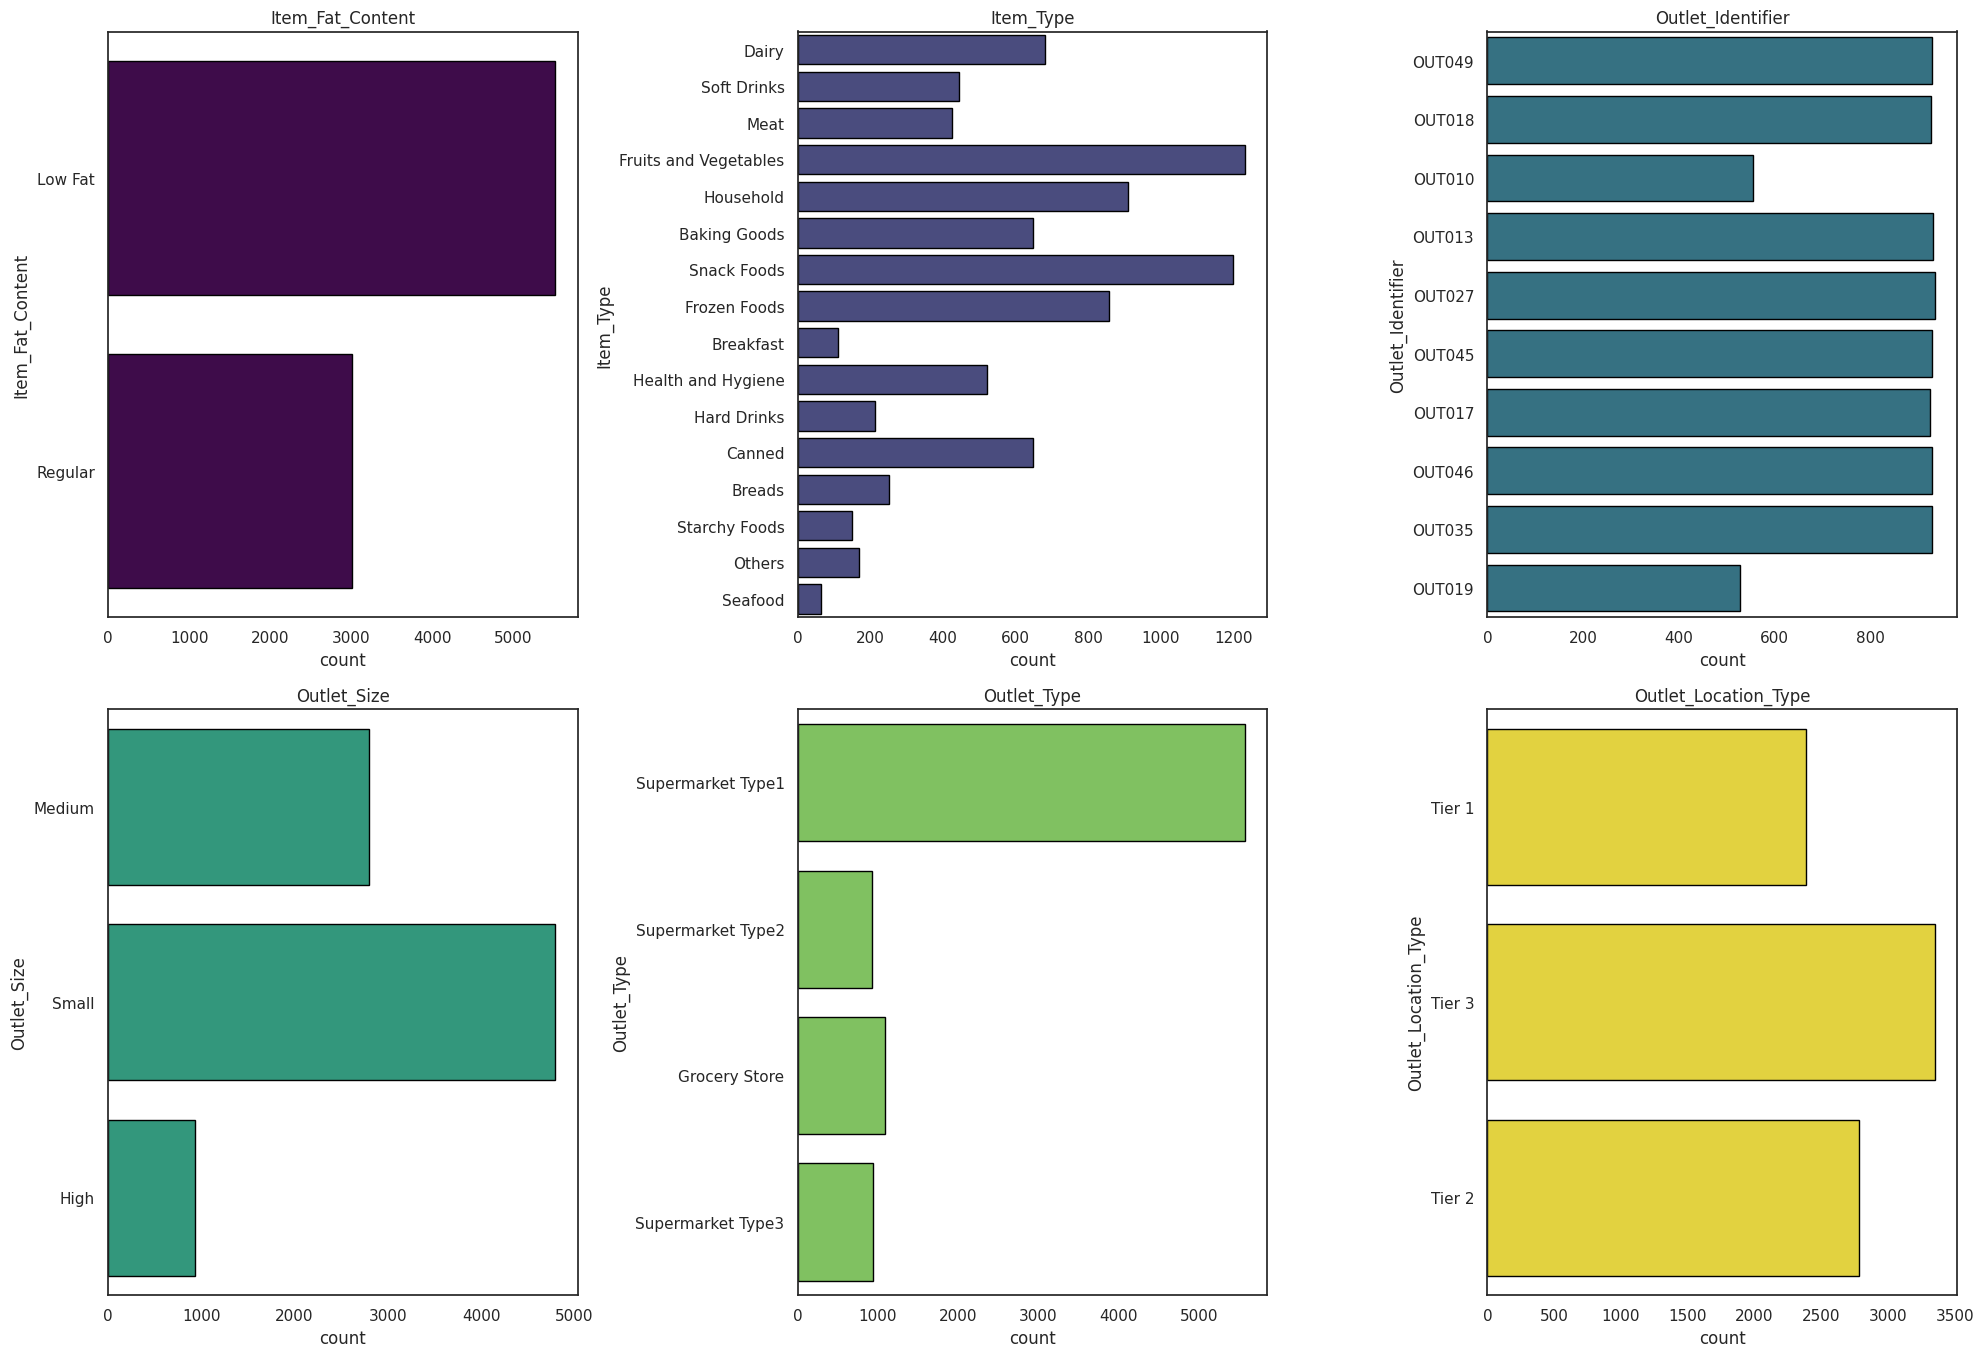

In [17]:
plt.figure(figsize=(20, 20))
sns.set(style="white", palette="muted")
colors = plt.cm.viridis(np.linspace(0, 1, len(x[['Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Type','Outlet_Location_Type']].columns)))

for i, col in enumerate(x[['Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Type','Outlet_Location_Type']].columns):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x[['Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Size','Outlet_Type','Outlet_Location_Type']][col], color=colors[i], edgecolor="black")
    plt.title(col)
    plt.tight_layout()

plt.show()

**Split**

In [18]:
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.3, random_state=42)

**Scaling and Encoding**

In [19]:
scaler_features=['Item_Weight','Item_Visibility',	'Item_MRP',	'Outlet_Establishment_Year']
one_hot_encoder=['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier','Outlet_Type', 'Outlet_Location_Type']
ordinal_encoder=['Outlet_Size']

In [20]:
transformer=ColumnTransformer(
    transformers= [
        ('Standard_Scaler', MinMaxScaler(), scaler_features),
        ('One_Hot_Encoder', OneHotEncoder(sparse_output=False,drop='first'), one_hot_encoder),
        ('Ordinal_Encoder', OrdinalEncoder(categories=[['Small','Medium','High']]), ordinal_encoder),
        ],
        remainder='passthrough'
)

In [21]:
x_train_transformed=transformer.fit_transform(x_train)
x_test_transformed=transformer.transform(x_test)

### **Machine Learning**

**XGBoost**

***Hyperparameter Tuning***

In [22]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

xgb_grid_search.fit(x_train_transformed, y_train)

print(f"Best Parameters: {xgb_grid_search.best_params_}")
print(f"Best CV Score: {-xgb_grid_search.best_score_}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best CV Score: 1206267.7076901486


***Predicted Y***

In [30]:
xgb_y_predict = xgb_grid_search.predict(x_test_transformed)

In [31]:
np.set_printoptions(threshold=np.inf)
print(xgb_y_predict)

[ 1.23617297e+03  7.53129333e+02  7.61777649e+02  4.80849072e+03
  3.29283252e+03  7.34776184e+02  5.54251172e+03  1.99476270e+03
  1.54639526e+03  2.66310718e+03  6.48329224e+02  5.77453613e+02
  4.04490454e+03  8.04538269e+02  8.86892822e+02  4.05758691e+03
  1.83018188e+03  1.65349463e+03  2.03770898e+03  2.78765479e+03
  3.11952393e+03  2.75411743e+03  3.15686890e+03  2.52130884e+03
  3.88356274e+03  1.32493872e+03  3.80800903e+02  4.11768701e+03
  3.14644238e+03  4.08193750e+03  8.17597717e+02  2.78547290e+03
  2.08610913e+03  3.25960913e+03  3.93098907e+02  1.28969421e+03
  8.55851624e+02  1.99842114e+03  1.29826160e+03  2.81138916e+03
  4.13070587e+02  2.05518506e+03  1.45313452e+03  1.52517529e+03
  2.48763843e+03  1.38238428e+03  9.85466431e+02  9.16259583e+02
  4.04490454e+03  1.97939148e+03  8.25479492e+02  2.09605322e+03
  9.14132263e+02  1.28340439e+02  7.49684021e+02  1.83018188e+03
  3.09591406e+03  2.12582227e+03  7.49684021e+02  4.04490454e+03
  9.46240112e+02  6.87731

***Metrics***

In [32]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, xgb_y_predict)
print(f"Mean Squared Error: {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, xgb_y_predict)
print(f"Mean Absolute Error: {mae}")

# R² Score
r2 = r2_score(y_test, xgb_y_predict)
print(f"R² Score: {r2}")

Mean Squared Error: 1124134.8187402857
Root Mean Squared Error: 1060.2522429781914
Mean Absolute Error: 749.3468408311529
R² Score: 0.5986656849581395


***Scatter Plot***

Text(0, 0.5, 'Predicted Values')

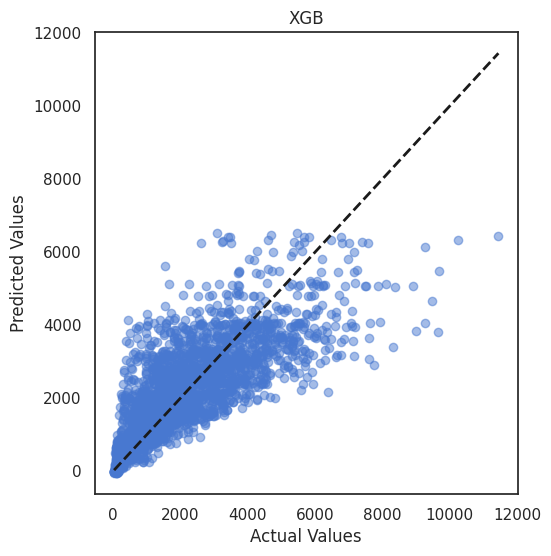

In [55]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, xgb_y_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('XGB')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')


***Residual Plot***

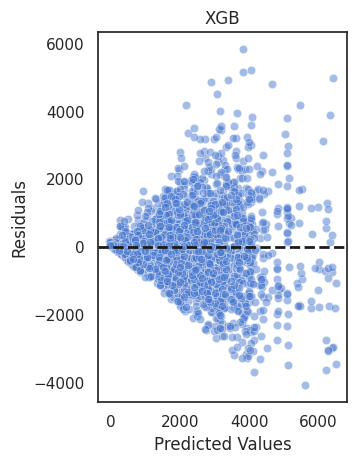

In [54]:
residuals = y_test - xgb_y_predict
plt.subplot(1, 2, 2)
sns.scatterplot(x=xgb_y_predict, y=residuals, alpha=0.5)
plt.axhline(0, color='k', linestyle='--', lw=2)
plt.title('XGB')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

**Linear Regression**

In [37]:
lr=LinearRegression()
lr.fit(x_train_transformed, y_train)

LinearRegression()

***Predicted Y***

In [38]:
lr_y_predict=lr.predict(x_test_transformed)

In [39]:
print(lr_y_predict)

[ 1.337125e+03  7.013750e+02  8.773750e+02  4.227375e+03  3.352875e+03
  6.073750e+02  4.732375e+03  2.077375e+03  1.403875e+03  2.818875e+03
 -2.345000e+02  2.125250e+03  3.921625e+03  9.848750e+02  7.328750e+02
  4.340625e+03  1.749875e+03  1.822125e+03  1.973125e+03  3.210250e+03
  3.081375e+03  2.705375e+03  2.829125e+03  2.489375e+03  4.236625e+03
  2.220125e+03  7.960000e+02  3.812875e+03  3.191375e+03  3.887875e+03
  8.165000e+02  2.771500e+03  2.382875e+03  3.103625e+03  6.221250e+02
  1.449125e+03  7.591250e+02  1.989125e+03  1.215125e+03  2.904375e+03
 -7.027500e+02  2.190125e+03  1.536125e+03  1.567625e+03  2.584875e+03
  1.463375e+03  6.821250e+02  9.282500e+02  4.141875e+03  2.032375e+03
  8.868750e+02  2.333875e+03  1.086125e+03 -1.076125e+03  7.163750e+02
  1.801625e+03  3.004875e+03  2.194625e+03  7.098750e+02  3.896625e+03
  8.608750e+02  7.062500e+02  2.434000e+03  2.725000e+03  3.348625e+03
  2.637875e+03  1.004625e+03  3.666125e+03  7.501250e+02  4.381625e+03
  1.05

***Metrics***

In [40]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, lr_y_predict)
print(f"Mean Squared Error: {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, lr_y_predict)
print(f"Mean Absolute Error: {mae}")

# R² Score
r2 = r2_score(y_test, lr_y_predict)
print(f"R² Score: {r2}")

Mean Squared Error: 1209515.0028471744
Root Mean Squared Error: 1099.7795246535436
Mean Absolute Error: 810.074870394994
R² Score: 0.568183578065405


***Scatter Plot***

Text(0, 0.5, 'Predicted Values')

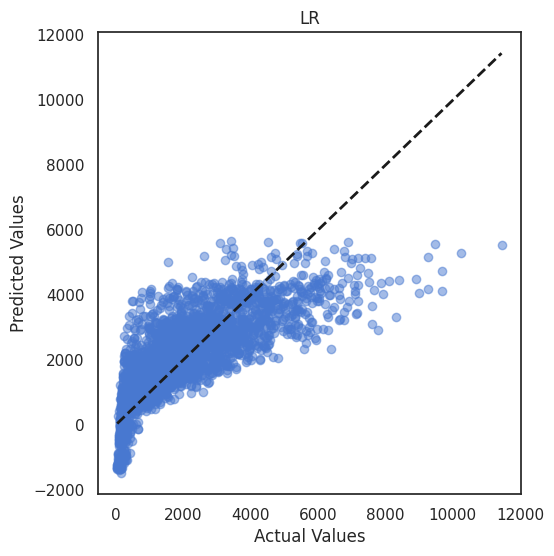

In [53]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_y_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('LR')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

***Residual Plot***

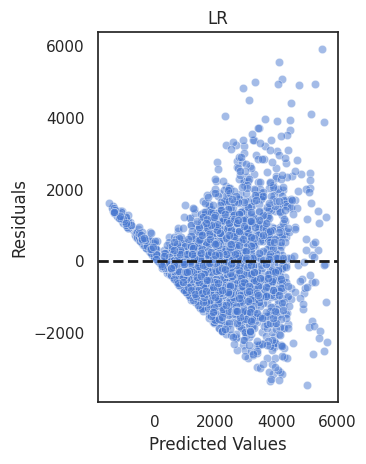

In [52]:
residuals = y_test - lr_y_predict
plt.subplot(1, 2, 2)
sns.scatterplot(x=lr_y_predict, y=residuals, alpha=0.5)
plt.axhline(0, color='k', linestyle='--', lw=2)
plt.title('LR')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

**KNN**

***Hyperparameter Tuning***

In [43]:
knn_param_grid={
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_regressor = KNeighborsRegressor()

In [44]:
knn_grid_search = GridSearchCV(
    estimator=knn_regressor,
    param_grid=knn_param_grid,
    cv=5, scoring='neg_mean_squared_error',
    n_jobs=-1)

knn_grid_search.fit(x_train_transformed, y_train)

print(f"Best Parameters: {knn_grid_search.best_params_}")
print(f"Best CV Score: {-knn_grid_search.best_score_}")

Best Parameters: {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
Best CV Score: 1528070.907346453


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


***Predicted y***

In [45]:
knn_y_predict=knn_grid_search.predict(x_test_transformed)

In [46]:
print(knn_y_predict)

[1600.06171083 1301.0654295  1514.22910707 4872.39302334 3659.73725293
 1076.97333412 4532.32528437 2336.10118695 1326.90634597 2674.10183104
  345.46759012  327.76370784 5122.55297689  998.88972508  988.61938323
 4215.77537547 1536.16582238 1040.20054001 2233.44381579 2957.29668435
 2774.23184799 2517.75978799 3143.41466031 2147.08925009 3320.16804313
 1523.13926335  345.81294006 3555.5309903  3731.73679422 2928.90298655
 1274.84601511 3279.48478376 1865.18409896 3161.95905199  454.12367105
 1219.36187027 2090.71620011 1411.48522385 1001.33243434 1693.88487241
  220.86379344 2939.77777879 1984.87471546 1866.44663907 1764.80127619
 1306.7716343  1377.27061333  930.93067554 3622.29890172 2011.02887162
 1370.04203013 1805.76541153 1078.5171579   239.71517016 1065.00883832
 2524.72738265 2911.86794564 1898.81888369  987.5931584  3055.59660747
 1264.28493564  371.5728546  2642.35852605 2489.27488271 3570.65368961
 1902.57064174 1403.49682302 3612.51289277 1031.85987715 3181.69959009
 1400.

***Metrics***

In [47]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, knn_y_predict)
print(f"Mean Squared Error: {mse}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, knn_y_predict)
print(f"Mean Absolute Error: {mae}")

# R² Score
r2 = r2_score(y_test, knn_y_predict)
print(f"R² Score: {r2}")

Mean Squared Error: 1445075.049642372
Root Mean Squared Error: 1202.1127441477242
Mean Absolute Error: 864.2657700141467
R² Score: 0.48408483078372255


***Scatter Plot***

Text(0, 0.5, 'Predicted Values')

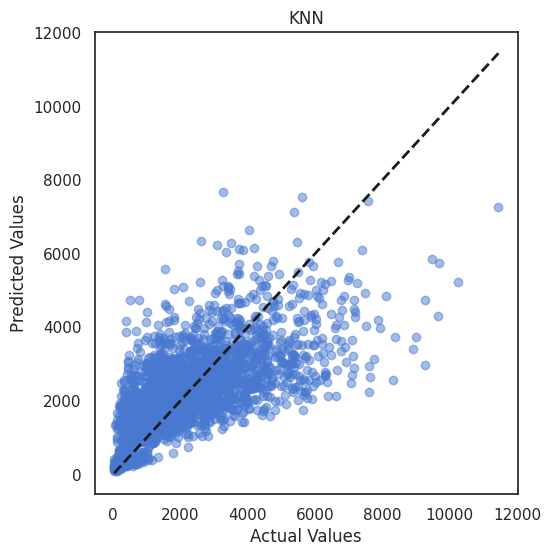

In [51]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, knn_y_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('KNN')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

***Residual Plot***

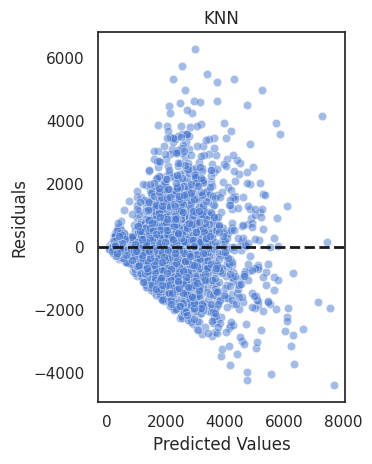

In [50]:
residuals = y_test - knn_y_predict
plt.subplot(1, 2, 2)
sns.scatterplot(x=knn_y_predict, y=residuals, alpha=0.5)
plt.axhline(0, color='k', linestyle='--', lw=2)
plt.title('KNN')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()